# Importing libraries

In [70]:
# %load "../../02. src/01. Bootstrapping/init.py"
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd
from datetime import datetime
import pandas_profiling

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import xgboost
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
%matplotlib notebook
from boruta import BorutaPy

from keras.models import Sequential
from keras.layers import Dense, Dropout

from scipy.stats import skew
from scipy.special import boxcox1p
from scipy import stats
from scipy.stats import norm

import pickle

np.random.seed(940702)

# Reading pickle from EDA notebook

In [71]:
df_train = pd.read_pickle('../../04. model/01. eda/eda_df_train.pkl')

In [72]:
df_train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [73]:
df_test = pd.read_csv('../../01. data/01. raw/test.csv')


# Imputations

In [74]:
#missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [75]:
#In summary, to handle missing data, we'll delete all the variables with missing data, except the variable 'Electrical'.
#In 'Electrical' we'll just delete the observation with missing data.

In [76]:
#dealing with missing data
df_train = df_train.drop((missing_data[missing_data['Total'] > 1]).index,1)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)
df_train.isnull().sum().max() #just checking that there's no missing data missing..

#dealing with missing data
df_test = df_test.drop((missing_data[missing_data['Total'] > 1]).index,1)
df_test = df_test.drop(df_test.loc[df_test['Electrical'].isnull()].index)
df_test.isnull().sum().max() #just checking that there's no missing data missing..

0

4

In [77]:
df_test.fillna(0, inplace=True)

In [78]:
df_test.isnull().sum().max()

0

# Outliers

<IPython.core.display.Javascript object>


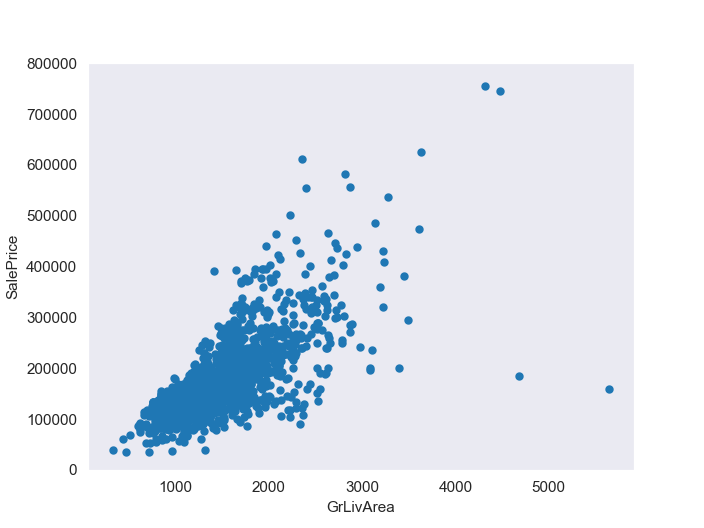

In [79]:
#bivariate analysis saleprice/grlivarea
plt.close()
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

In [80]:
#deleting points
df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]
df_train = df_train.drop(df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(df_train[df_train['Id'] == 524].index)

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,63887,Pave,IR3,Bnk,AllPub,Corner,Gtl,...,0,0,0,480,0,1,2008,New,Partial,160000
523,524,60,RL,40094,Pave,IR1,Bnk,AllPub,Inside,Gtl,...,0,0,0,0,0,10,2007,New,Partial,184750


# Assumption Testing

## According to Hair et al. (2013), four assumptions should be tested:

1. Normality - 

When we talk about normality what we mean is that the data should look like a normal distribution. This is important because several statistic tests rely on this (e.g. t-statistics). In this exercise we'll just check univariate normality for 'SalePrice' (which is a limited approach). Remember that univariate normality doesn't ensure multivariate normality (which is what we would like to have), but it helps. Another detail to take into account is that in big samples (>200 observations) normality is not such an issue. However, if we solve normality, we avoid a lot of other problems (e.g. heteroscedacity) so that's the main reason why we are doing this analysis.

2. Homoscedasticity - 

Homoscedasticity refers to the 'assumption that dependent variable(s) exhibit equal levels of variance across the range of predictor variable(s)' Homoscedasticity is desirable because we want the error term to be the same across all values of the independent variables.

3. Linearity- 

The most common way to assess linearity is to examine scatter plots and search for linear patterns. If patterns are not linear, it would be worthwhile to explore data transformations. However, we'll not get into this because most of the scatter plots we've seen appear to have linear relationships.

4. Absence of correlated errors- 

Correlated errors, like the definition suggests, happen when one error is correlated to another. For instance, if one positive error makes a negative error systematically, it means that there's a relationship between these variables. This occurs often in time series, where some patterns are time related. We'll also not get into this. However, if you detect something, try to add a variable that can explain the effect you're getting. That's the most common solution for correlated errors.

## Normality

<IPython.core.display.Javascript object>


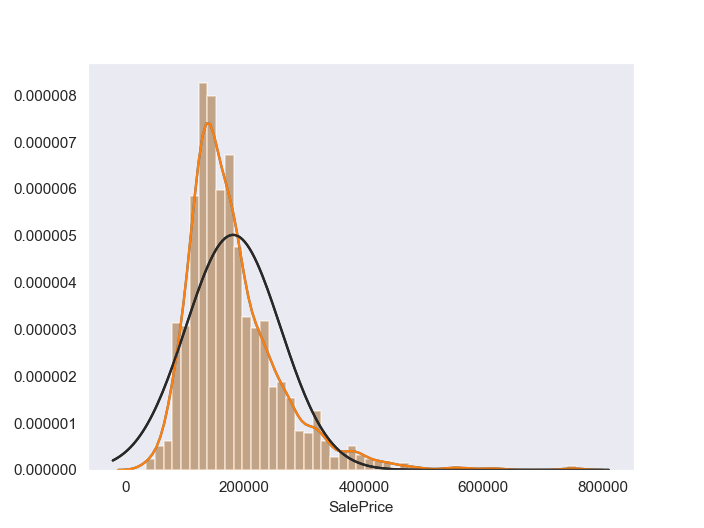

<IPython.core.display.Javascript object>


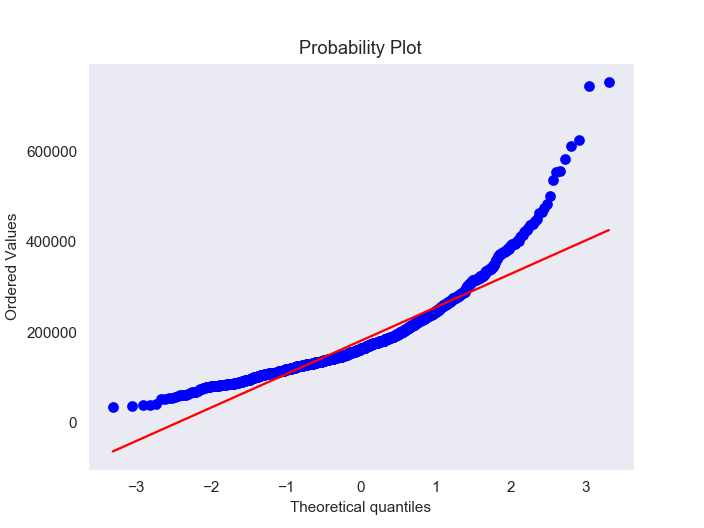

In [81]:
#transformed histogram and normal probability plot
plt.close()
#transformed histogram and normal probability plot
pl = sns.distplot(df_train['SalePrice'], fit=norm);
pl
pl.figure.savefig('../../04. model/02. preprocessing/target_normal.png')
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

In [53]:
#applying log transformation
df_train['SalePrice'] = np.log(df_train['SalePrice'])

<IPython.core.display.Javascript object>


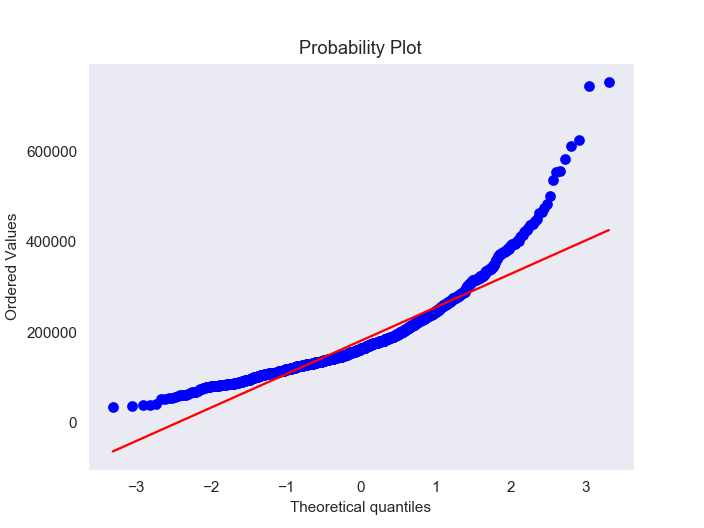

In [82]:
#transformed histogram and normal probability plot
plt.close()
sns.distplot(df_train['SalePrice'], fit=norm)
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

In [14]:
len_train=df_train.shape[0]
houses=pd.concat([df_train,df_test], sort=False)

# train=houses[:df_train]
# test=houses[df_train:]

# Handling ordinal features

# Removing Skewness

In [83]:
skw = houses.select_dtypes(include=['int','float']).apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

skew_df=pd.DataFrame({'Skew':skw})
skewed_df=skew_df[(skew_df['Skew']>0.5)|(skew_df['Skew']<-0.5)]

In [84]:
skewed_df.index

Index(['PoolArea', '3SsnPorch', 'LowQualFinSF', 'MiscVal', 'BsmtHalfBath',
       'ScreenPorch', 'KitchenAbvGr', 'BsmtFinSF2', 'EnclosedPorch',
       'MasVnrArea', 'HalfBath', 'YearBuilt', 'LotArea', 'BsmtFinSF1',
       'OverallCond', 'BsmtUnfSF', 'TotalBsmtSF'],
      dtype='object')

In [85]:
df_train=houses[:len_train]
df_test=houses[len_train:]

In [86]:
lam=0.1
for col in ('MiscVal', 'PoolArea', 'LotArea', 'LowQualFinSF', '3SsnPorch',
       'KitchenAbvGr', 'BsmtFinSF2', 'EnclosedPorch', 'ScreenPorch',
       'BsmtHalfBath', 'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF',
       'LotFrontage', 'GrLivArea', 'BsmtFinSF1', 'BsmtUnfSF', 'Fireplaces',
       'HalfBath', 'TotalBsmtSF', 'BsmtFullBath', 'OverallCond', 'YearBuilt',
       'GarageYrBlt'):
    df_train[col]=boxcox1p(df_train[col],lam)
    df_test[col]=boxcox1p(df_test[col],lam)

## Homoscedasticity

The best approach to test homoscedasticity for two metric variables is graphically. Departures from an equal dispersion are shown by such shapes as cones (small dispersion at one side of the graph, large dispersion at the opposite side) or diamonds (a large number of points at the center of the distribution).

In [87]:
#sns.pairplot(df_train)

# One-hot encoding

In [88]:
df_train.fillna(0, inplace=True)
df_test.fillna(0, inplace=True)

In [89]:
len_train=df_train.shape[0]
houses=pd.concat([df_train,df_test], sort=False)

houses=pd.get_dummies(houses)

df_train=houses[:len_train]
df_test=houses[len_train:]

# Scaling

In [90]:
x=df_train.drop('SalePrice', axis=1)
y=df_train['SalePrice']
df_test=df_test.drop('SalePrice', axis=1)

In [91]:
x=x.drop('Id', axis=1)
Id = df_test['Id']
df_test=df_test.drop('Id', axis=1)

In [92]:
sc=RobustScaler()
x=sc.fit_transform(x)
df_test=sc.transform(df_test)

In [93]:
pickle.dump(sc, open('../../04. model/02. preprocessing/RobustScaler.sav', 'wb'))

# Pickling output datasets

In [94]:
with open('../../04. model/02. preprocessing/x.pkl','wb') as f:
    pickle.dump(x, f)
    
with open('../../04. model/02. preprocessing/y.pkl','wb') as f:
    pickle.dump(y, f)
    
with open('../../04. model/02. preprocessing/df_test.pkl','wb') as f:
    pickle.dump(df_test, f)
    
with open('../../04. model/02. preprocessing/Id.pkl','wb') as f:
    pickle.dump(Id, f)